In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
import csv
from datetime import datetime
from collections import Counter
from statistics import median, mean
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter

from datetime import datetime
from datetime import timedelta


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import DistanceMetric
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, scale
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression, LogisticRegression, MultiTaskElasticNet, ElasticNet, SGDClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

import xgboost as xgb

import matplotlib.pyplot as plt

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Dropout, Activation, Input, concatenate
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
df = pd.read_excel('C:/Users/Amara/Downloads/Covid19 Prediction/Covid_Data2/new/rta_all_covid_demographics_per_test_with_outcome_and_empi_august_all.xlsx')
df = df[['PERSON_ID', 'Outcome', 'Test Date', 'Admit Date', 'Discharge Date', 'EMPI', 'NAME_FULL_FORMATTED', 'GENDER', 'RACE', 'ETHNIC_GROUP', 'AGE']]
selected_targets = ['Hospitalized', 'Self Isolation']
df = df.loc[df.Outcome.isin(selected_targets)]
print(df.columns)

df = df.replace({'RACE': {' ': 'Unknown, Unavailable or Unreported'}})
df = df.replace({'RACE': {'Native Hawaiian or Other Pacific Islande': 'Native Hawaiian or Other Pacific Islander'}})
df = df.replace({'ETHNIC_GROUP': {' ': 'Unreported, Unknown, Unavailable'}})
df = df.replace({'ETHNIC_GROUP': {'Not Recorded': 'Unreported, Unknown, Unavailable'}})
print(set(df['RACE'].values))
print(set(df['ETHNIC_GROUP'].values))
discrete_feats = ['GENDER', 'RACE', 'ETHNIC_GROUP']
continuous_feats = ['AGE']
print(len(df))

Index(['PERSON_ID', 'Outcome', 'Test Date', 'Admit Date', 'Discharge Date',
       'EMPI', 'NAME_FULL_FORMATTED', 'GENDER', 'RACE', 'ETHNIC_GROUP', 'AGE'],
      dtype='object')
{'Caucasian or White', 'Native Hawaiian or Other Pacific Islander', 'Multiple', 'Unknown, Unavailable or Unreported', 'Asian', 'American Indian or Alaskan Native', 'African American  or Black'}
{'Hispanic or Latino', 'Non-Hispanic or Latino', 'Unreported, Unknown, Unavailable'}
3023


In [3]:
df_pres = pd.read_excel('C:/Users/Amara/Downloads/Covid19 Prediction/Covid_Data2/new/August_Update/Patients_august_all_MedGroups_current3_history_visits.xlsx')
df_pres.head(2)

,Unnamed: 0,PERSON_ID,Outcome,Outcome_DT,Visit Type,Visit Start DT,Visit End DT,Anti-hypertensive,Steroid,Diabetes,...,Pressor,Fluid,Respiratory,Vasodilator,anti-hypertensive,Thyroid,Antibiotic,Pain (opioid),Cardiovascular,Insulin
0,0,98845897,Self Isolation,2020-03-27,current,2020-03-12,2020-03-27,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,98845897,Self Isolation,2020-03-27,history,2018-01-01,2020-03-11,0,3,0,...,0,0,1,0,0,0,0,0,0,0


In [4]:
df_icd = pd.read_excel('C:/Users/Amara/Downloads/Covid19 Prediction/Covid_Data2/new/August_Update/Patients_august_all_ICD9_current3_history_visits.xlsx')
df_icd.head(2)

,Unnamed: 0,PERSON_ID,Outcome,Outcome_DT,Visit Type,Visit Start DT,Visit End DT,96,86,46,...,120,71,105,21,99,27,28,104,18,6
0,0,98845897,Self Isolation,2020-03-27,current,2020-03-12,2020-03-27,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,98845897,Self Isolation,2020-03-27,history,2018-01-01,2020-03-11,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df_cpt = pd.read_excel('C:/Users/Amara/Downloads/Covid19 Prediction/Covid_Data2/new/August_Update/Patients_august_all_CPT_current3_history_visits.xlsx')
df_cpt.head(2)

,Unnamed: 0,PERSON_ID,Outcome,Outcome_DT,Visit Type,Visit Start DT,Visit End DT,71045,80053,82330,...,J1100,P9040,J9047,J2920,J1720,94660,84550,85045,J2248,J0289
0,0,98845897,Self Isolation,2020-03-27,current,2020-03-12,2020-03-27,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,98845897,Self Isolation,2020-03-27,history,2018-01-01,2020-03-11,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df_lab = pd.read_excel('C:/Users/Amara/Downloads/Covid19 Prediction/Covid_Data2/new/August_Update/Patients_august_all_Labs_current3_history_visits.xlsx')
df_lab.head(2)

,Unnamed: 0,PERSON_ID,Outcome,Outcome_DT,Visit Type,Visit Start DT,Visit End DT,AG,Red Cell Distribution Width-CV,"Auto Nucleated Red Bood Cell, Absolute",...,MCV,"Osmolality, Calculated",Hemoglobin,Carbon Dioxide Level,Albumin Level,Aspartate Aminotransferase,Protein Total,Bilirubin Total,Alanine Aminotransferase,Alkaline Phosphatase
0,0,98845897,Self Isolation,2020-03-27,current,2020-03-12,2020-03-27,Unknown,Unknown,Unknown,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
1,1,98845897,Self Isolation,2020-03-27,history,2018-01-01,2020-03-11,Unknown,Unknown,Unknown,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown


In [7]:
pids_sel = df.PERSON_ID.values
target = df.Outcome.values

print(Counter(np.array(target)))

target = np.array([0 if target[i] == 'Self Isolation' else 1 for i in range(0, len(target))])
print(Counter(np.array(target)))
class_weights = class_weight.compute_class_weight('balanced', [0,1], target)
print(class_weights)
print(len(pids_sel), len(target))

Counter({'Hospitalized': 1599, 'Self Isolation': 1424})
Counter({1: 1599, 0: 1424})
[1.06144663 0.9452783 ]
3023 3023


In [10]:
# train_idx, test_idx = train_test_split( [i for i in range(target.shape[0])], test_size=0.2)
# idx = {}
# idx['train_idx'] = train_idx
# idx['test_idx'] = test_idx
# pkl.dump(idx , open( "C:/Users/Amara/Downloads/Covid19 Prediction/Covid_Data2/new/August_Update/train_test_split_Patients_august_all_current3_history.pkl", "wb" ) )

In [8]:
#Labs + demo: contains all patients with labs info. so the same train test split can be used
idx = pkl.load(open( "C:/Users/Amara/Downloads/Covid19 Prediction/Covid_Data2/new/August_Update/train_test_split_Patients_august_all_current3_history.pkl", "rb" ))
train_idx = idx['train_idx']
test_idx = idx['test_idx']
Counter(target[test_idx])
#print(len(train_idx)+len(test_idx))

Counter({1: 328, 0: 277})

In [9]:
#MedGroups data curation
selected_pres = ['Anti-hypertensive', 'Pain (opioid)',
       'Pain (non-opioid)', 'Pressor', 'Insulin', 'Steroid', 'Antibiotic',
       'Diabetes', 'Anesthesia', 'Thyroid', 'Electrolyte', 'Diuretic',
       'Respiratory', 'Statin', 'Cardiovascular', 'Fluid', 'Anxiolytic',
       'Anticoagulant', 'Anti-epileptic', 'anti-hypertensive', 'Vasodilator']

mat = df_pres[selected_pres].copy().to_numpy()
v1_idx = [i for i in range(0, mat.shape[0], 2)]
v2_idx = [i for i in range(1, mat.shape[0], 2)]
print(mat.shape)
X_pres = np.concatenate((mat[v1_idx,:], mat[v2_idx, :]), axis = 1)
scaler = MinMaxScaler()#scale between 0 and 1
scaler.fit(X_pres)
X_pres_norm = scaler.transform(X_pres)
print(X_pres_norm.shape)
print(X_pres)
features = selected_pres
feats_pres = []
for f in features:
    feats_pres.append(f+'_01')
for f in features:
    feats_pres.append(f+'_02')

(6046, 21)
(3023, 42)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 2 1 ... 1 0 0]
 [1 0 0 ... 0 0 0]]


In [10]:
#ICD data curation
selected_ICD = [96, 86, 46, 137, 75, 129, 141, 78, 60, 128, 119, 95, 36, 88, 47, 55, 48, 45, 61, 131, 85, 50, 87, 39, 130, 69, 56, 76, 79, 133, 107, 140, 34, 127, 66, 42, 134, 44, 30, 63, 67, 125, 31, 65, 51, 68, 139, 33, 77, 81, 97, 62, 72, 136, 121, 101, 59, 135, 92, 64, 38, 73, 41, 43, 132, 24, 70, 80, 138, 126, 94, 83, 32, 112, 122, 106, 118, 57, 20, 82, 53, 58, 84, 111, 35, 54, 117, 108, 123, 103, 37, 22, 116, 91, 9, 3, 12, 74, 49, 114, 110, 7, 4, 5, 120, 71, 105, 21, 99, 27, 28, 104, 18, 6]
to_be_removed = []#111, 119, 129, 140, 141]
selected_ICD = [s for s in selected_ICD if s not in to_be_removed]

mat = df_icd[selected_ICD].copy().to_numpy()
v1_idx = [i for i in range(0, mat.shape[0], 2)]
v2_idx = [i for i in range(1, mat.shape[0], 2)]
print(mat.shape)
X_icd = np.concatenate((mat[v1_idx,:], mat[v2_idx, :]), axis = 1)
#scale between 0 and 1
scaler = MinMaxScaler()
scaler.fit(X_icd)
X_icd_norm = scaler.transform(X_icd)
print(X_icd_norm.shape)
print(X_icd)
df_ICD9 = pd.read_excel('C:/Users/Amara/Downloads/Covid19 Prediction/Covid_Data2/new/ICD-9 Groups.xlsx')
features = []
for s in selected_ICD:
    temp = df_ICD9.loc[df_ICD9['Subgroup No.']==s]
    features.append(str(temp.at[temp.index[0], 'Subgroup Description']))
feats_icd = []
for f in features:
    feats_icd.append(str(f)+'_01')
for f in features:
    feats_icd.append(str(f)+'_02')

(6046, 114)
(3023, 228)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 4 ... 0 0 0]]


In [11]:
#CPT data curation
selected_CPT = ['71045', '80053', '82330', '82375', '82435', '82805', '82947', '83050', '83605', '84132', '84295', '85025', '85610', '87040', '87631', '93005', '99284', 'J7040', '82962', '83880', '96365', '96375', '99285', 'J0456', 'J0696', 'J1650', 'J7120', '71046', '36415', '83735', '85027', '36430', '81003', '83690', '85014', '85018', '86850', '86900', '86901', '86923', '96366', 'C9113', 'J2405', 'J7030', 'P9016', '80048', '82570', '84100', '85730', 'J1940', 'J2370', '83036', '82607', 'J1815', '82728', '83540', '83550', 'J3475', '88305', '87077', '94640', '94664', '87340', '94760', '94799', 'J7050', '36600', '83615', '84484', '93306', 'J0692', '74018', '94770', 'J2704', 'J3010', '80197', '80061', '85379', '87497', '96361', '96374', 'J2060', '84439', '84443', '85007', '99214', '87086', '87088', '71260', '86140', 'J2765', 'Q9967', '82550', '81001', 'C1751', '97161', '97535', '94762', 'J2543', 'J3370', '99283', '84145', '96360', 'J1885', 'J3535', '74177', 'J0690', 'J1644', 'J2250', '96413', 'J1200', 'Q0162', 'Q0163', '81025', '96372', 'J2270', '86828', 'C1766', 'C1769', 'C1894', 'J2001', 'J7507', '99213', 'J7799', 'J0713', '83520', '87070', '87205', '85520', '87635', '85384', '94003', 'J7613', '80202', '94668', '97162', 'J0360', '82306', '85300', '87186', 'J2260', '70450', 'J2185', 'J1170', 'G0378', 'P9037', '97116', '97530', 'J7510', '97110', '86706', '90935', '80069', '74176', '80076', '97165', '96376', 'J7517', 'J1100', 'P9040', 'J9047', 'J2920', 'J1720', '94660', '84550', '85045', 'J2248', 'J0289'] 
mat = df_cpt[selected_CPT].copy().to_numpy()

v1_idx = [i for i in range(0, mat.shape[0], 2)]
v2_idx = [i for i in range(1, mat.shape[0], 2)]
print(mat.shape)
X_cpt = np.concatenate((mat[v1_idx,:], mat[v2_idx, :]), axis = 1)
#scale between 0 and 1
scaler = MinMaxScaler()
scaler.fit(X_cpt)
X_cpt_norm = scaler.transform(X_cpt)
print(X_cpt_norm.shape)
print(X_cpt)
dct = pkl.load(open('CPT_code_descriptions_new.pkl', 'rb'))
features = selected_CPT
feats_cpt = []
for f in features:
    feats_cpt.append(dct[f]+'_01')
for f in features:
    feats_cpt.append(dct[f]+'_02')
print(len(feats_cpt))

(6046, 168)
(3023, 336)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 4 1 ... 0 0 0]
 [1 6 2 ... 0 0 0]
 [0 1 0 ... 0 0 0]]
336


In [12]:
#lab data curation
selected_labs = ['AG', 'Red Cell Distribution Width-CV', 'Auto Nucleated Red Bood Cell, Absolute', 'Estimated GFR, African American', 'Glucose', 'Potassium Level', 'MCHC', 'Auto Nucleated Red Cell Count', 'Estimated GFR, Non African American', 'Chloride Level', 'Mean Platelet Volume', 'Calcium Level Total', 'Creatinine', 'MCH', 'Platelet Count', 'Sodium Level', 'Blood Urea Nitrogen', 'White Blood Count', 'Hematocrit', 'Red Blood Cell Count', 'MCV', 'Osmolality, Calculated', 'Hemoglobin', 'Carbon Dioxide Level', 'Albumin Level', 'Aspartate Aminotransferase', 'Protein Total', 'Bilirubin Total', 'Alanine Aminotransferase', 'Alkaline Phosphatase']

npd_discrete = df_lab[selected_labs].copy().to_numpy() 
enc = OneHotEncoder()
enc.fit(npd_discrete)
print(enc.categories_)
mat = enc.transform(npd_discrete).todense()
print(len(selected_labs), len(enc.categories_))
features = []
for i in range(len(selected_labs)):
    #print(i)
    l = selected_labs[i]
    for c in enc.categories_[i]:
        features.append(l+'_'+c)
features_old = features
v1_idx = [i for i in range(0, mat.shape[0], 2)]
v2_idx = [i for i in range(1, mat.shape[0], 2)]
X_lab = np.concatenate((mat[v1_idx,:], mat[v2_idx, :]), axis = 1)
print(X_lab.shape)
X_lab_norm = X_lab
print(X_lab)
feats_lab = []
for f in features:
    feats_lab.append(f+'_01')
for f in features:
    feats_lab.append(f+'_02')

[array(['Abnormal', 'Unknown'], dtype=object), array(['Abnormal', 'Normal', 'Unknown'], dtype=object), array(['Abnormal', 'Normal', 'Unknown'], dtype=object), array(['Abnormal', 'Normal', 'Unknown'], dtype=object), array(['Abnormal', 'Normal', 'Unknown'], dtype=object), array(['Abnormal', 'Normal', 'Unknown'], dtype=object), array(['Abnormal', 'Normal', 'Unknown'], dtype=object), array(['Abnormal', 'Normal', 'Unknown'], dtype=object), array(['Abnormal', 'Normal', 'Unknown'], dtype=object), array(['Abnormal', 'Normal', 'Unknown'], dtype=object), array(['Abnormal', 'Normal', 'Unknown'], dtype=object), array(['Abnormal', 'Normal', 'Unknown'], dtype=object), array(['Abnormal', 'Normal', 'Unknown'], dtype=object), array(['Abnormal', 'Normal', 'Unknown'], dtype=object), array(['Abnormal', 'Normal', 'Unknown'], dtype=object), array(['Abnormal', 'Normal', 'Unknown'], dtype=object), array(['Abnormal', 'Normal', 'Unknown'], dtype=object), array(['Abnormal', 'Normal', 'Unknown'], dtype=object), a

In [13]:
#prepare demographics data

npd_discrete = df[discrete_feats].copy().to_numpy()
enc = OneHotEncoder()
enc.fit(npd_discrete)
npd_cat = enc.transform(npd_discrete)
print(npd_cat.shape)
#print(enc.categories_)

features = []
for i in range(len(discrete_feats)):
    #print(i)
    l = discrete_feats[i]
    for c in enc.categories_[i]:
        features.append(l+'_'+c)
#npd_continuous = temp[continuous_feats].copy().to_numpy()
npd_continuous = df[continuous_feats].copy().to_numpy()
#scale between 0 and 1
scaler = MinMaxScaler()
npd_continuous = scaler.fit_transform(npd_continuous)
print(npd_continuous.shape, np.min(npd_continuous), np.max(npd_continuous))
X_demo = np.concatenate([npd_cat.todense(),  npd_continuous], axis=1) #, 
print(X_demo.shape)

feats_demo = np.array(features + continuous_feats)
print(X_demo.shape, len(feats_demo))
print(X_demo)

(3023, 13)
(3023, 1) 0.0 1.0
(3023, 14)
(3023, 14) 14
[[1.         0.         0.         ... 1.         0.         0.19417476]
 [1.         0.         0.         ... 1.         0.         0.46601942]
 [0.         1.         0.         ... 1.         0.         0.60194175]
 ...
 [1.         0.         0.         ... 0.         0.         0.45631068]
 [1.         0.         0.         ... 0.         0.         0.45631068]
 [1.         0.         0.         ... 1.         0.         0.61165049]]


In [14]:
#late Fusion

display_intermediate = 1

X_pres_train = X_pres[train_idx,:] 
X_pres_test = X_pres[test_idx,:] 
X_icd_train = X_icd[train_idx,:] 
X_icd_test = X_icd[test_idx,:] 
X_cpt_train = X_cpt[train_idx,:] 
X_cpt_test = X_cpt[test_idx,:] 
X_lab_train = X_lab[train_idx,:] 
X_lab_test = X_lab[test_idx,:] 
X_demo_train = X_demo[train_idx,:] 
X_demo_test = X_demo[test_idx,:]

y_train = target[train_idx] 
y_test = target[test_idx]

y_train = target[train_idx]
y_test = target[test_idx]

clf_demo = xgb.XGBClassifier(n_estimators=50, subsample=0.25)#LogisticRegression()#class_weight='balanced')#
#RandomForestClassifier(random_state=0, max_features='log2')#LogisticRegression()# 
clf_demo.fit(X_demo_train, y_train)

clf_pres = xgb.XGBClassifier(n_estimators=50, subsample=0.25)#RandomForestClassifier(random_state=0)#, class_weight='balanced')
#RandomForestClassifier(random_state=0, max_features='log2')#LogisticRegression()# 
clf_pres.fit(X_pres_train, y_train)

clf_icd = xgb.XGBClassifier(n_estimators=100, subsample=0.5) #RandomForestClassifier(random_state=0)#, class_weight='balanced')
#RandomForestClassifier(random_state=0, max_features='log2')#LogisticRegression()# 
clf_icd.fit(X_icd_train, y_train)

clf_cpt = RandomForestClassifier(random_state=0, max_features='log2')
#xgb.XGBClassifier(n_estimators=100, subsample=0.5)#, class_weight='balanced')#LogisticRegression()# 
clf_cpt.fit(X_cpt_train, y_train)

clf_lab = RandomForestClassifier(random_state=0, max_features='log2')#LogisticRegression()#
#xgb.XGBClassifier(n_estimators=20, subsample=0.25)#, class_weight='balanced')
clf_lab.fit(X_lab_train, y_train)

if display_intermediate==1: 
    y_pred = clf_demo.predict(X_demo_test) 
    print('Accuracy:\t', metrics.accuracy_score(y_test, y_pred)) 
    print(classification_report(y_test, y_pred, target_names=['0', '1']))

    y_pred = clf_pres.predict(X_pres_test)
    print('Accuracy:\t', metrics.accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=['0', '1']))

    y_pred = clf_icd.predict(X_icd_test)
    print('Accuracy:\t', metrics.accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=['0', '1']))

    y_pred = clf_cpt.predict(X_cpt_test)
    print('Accuracy:\t', metrics.accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=['0', '1']))

    y_pred = clf_lab.predict(X_lab_test)
    print('Accuracy:\t', metrics.accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=['0', '1']))

y_demo = clf_demo.predict_proba(X_demo_train)
y_pres = clf_pres.predict_proba(X_pres_train)
y_icd = clf_icd.predict_proba(X_icd_train)
y_cpt = clf_cpt.predict_proba(X_cpt_train)
y_lab = clf_lab.predict_proba(X_lab_train)

X_merged_train = np.concatenate((y_demo, y_pres, y_icd, y_cpt, y_lab), axis = 1)

y_demo = clf_demo.predict_proba(X_demo_test)
y_pres = clf_pres.predict_proba(X_pres_test)
y_icd = clf_icd.predict_proba(X_icd_test)
y_cpt = clf_cpt.predict_proba(X_cpt_test)
y_lab = clf_lab.predict_proba(X_lab_test)

X_merged_test = np.concatenate((y_demo, y_pres, y_icd, y_cpt, y_lab), axis = 1)

#scale between 0 and 1 
scaler = MinMaxScaler() 
X_merged = np.concatenate([X_merged_train, X_merged_test], axis=0)
#X_merged = X_merged[:,[0,2,4, 6, 8]]
jump = 2
scaler.fit(X_merged) 
X_merged_norm = scaler.transform(X_merged) 
#X_merged_norm = scale(X_merged_norm)
X_merged_train_norm = X_merged_norm[:len(train_idx),:] 
X_merged_test_norm = X_merged_norm[len(train_idx):,:]

# #l2 normalization
# X_merged_train_norm = normalize(X_merged_train, norm='l2')
# X_merged_test_norm = normalize(X_merged_test, norm='l2')

clf_lf = xgb.XGBClassifier(n_estimators=25, subsample=0.25)
#MLPClassifier(max_iter= 1500, solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(16,2), activation='tanh', random_state=1, tol = 1e-2)
#xgb.XGBClassifier(n_estimators=50, subsample=0.5)
#SVC(kernel='poly', degree=7, probability=True)

clf_lf.fit(X_merged_train_norm, y_train)
y_pred = clf_lf.predict(X_merged_test_norm)
print('Accuracy:\t', metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['0', '1'])) 
print(confusion_matrix(y_test, y_pred, labels= [0, 1]))

temp = pd.DataFrame()
temp['Late Fusion'] =  ['Demographics', 'Medications', 'ICD-9', 'CPT', 'Labs']
imps = [np.mean(clf_lf.feature_importances_[i:i+jump]) for i in range(0,clf_lf.feature_importances_.shape[0], jump)]
print(imps)
temp['Importance_SvH'] = imps
#temp.to_excel('Feature Importance\\feature_importance_curent3_5_modalities_CPT_updated_Late Fusion_august_all.xlsx')

Accuracy:	 0.6925619834710743
              precision    recall  f1-score   support

           0       0.68      0.63      0.65       277
           1       0.71      0.74      0.72       328

    accuracy                           0.69       605
   macro avg       0.69      0.69      0.69       605
weighted avg       0.69      0.69      0.69       605

Accuracy:	 0.6942148760330579
              precision    recall  f1-score   support

           0       0.62      0.86      0.72       277
           1       0.82      0.55      0.66       328

    accuracy                           0.69       605
   macro avg       0.72      0.71      0.69       605
weighted avg       0.73      0.69      0.69       605

Accuracy:	 0.7917355371900826
              precision    recall  f1-score   support

           0       0.74      0.84      0.79       277
           1       0.85      0.75      0.80       328

    accuracy                           0.79       605
   macro avg       0.79      0.80     

In [147]:
#early fusion

finetune = 1

X_merged = np.concatenate((X_demo, X_pres_norm, X_icd_norm, X_cpt_norm, X_lab_norm), axis = 1)
X_merged_train = X_merged[train_idx,:]
X_merged_test = X_merged[test_idx,:]
y_train = target[train_idx]
y_test = target[test_idx]

# train_flag = 1
# act = "tanh"
# opt = keras.optimizers.Adam(lr=0.00001)
# in_data = Input(shape=(X_merged.shape[1],))
# x = Dense(500, activation=act)(in_data)
# #x = Dense(1000, activation=act)(x)
# #x = Dense(500, activation=act)(x)
# x = Dense(250, activation=act)(x)
# x = Dense(50, activation=act)(x)
# out_data = Dense(1, activation=act)(x)
# clf_ef = Model(inputs=in_data, outputs=out_data)
# clf_ef.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
# clf_ef.summary()

# filepath="combined_model_demo_pres_icd_cpt_lab_early_fusion_ICU_split_2.hdf5"

# if train_flag == 1:
#     checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#     history = clf_ef.fit(X_merged_train, y_train, validation_split = 0.2, epochs=50, batch_size=64, callbacks = [checkpoint])
#     clf_ef.load_weights(filepath)
#     test_loss, test_acc = clf_ef.evaluate(X_merged_test, y_test, verbose=1)
#     print('Test Accuracy:\t'+str(test_acc))
#     print(history.history.keys())
#     plt.subplot(211)
#     plt.title('Loss')
#     plt.plot(history.history['loss'], label='train')
#     plt.plot(history.history['val_loss'], label='test')
#     plt.legend()
#     # plot accuracy during training
#     plt.subplot(212)
#     plt.title('Accuracy')
#     plt.plot(history.history['acc'], label='train')
#     plt.plot(history.history['val_acc'], label='test')
#     plt.legend()
#     plt.show()

# y_pred_prob = clf_ef.predict(X_merged_test)
# y_pred = np.array([1 if yy > 0.5 else 0 for yy in y_pred_prob])

clf_ef = xgb.XGBClassifier(n_estimators=25, subsample=0.9)
#xgb.XGBClassifier(n_estimators=27, subsample=0.9)
#
#SVC(kernel='rbf',  probability=True)
#RandomForestClassifier(random_state=0, max_features='log2')
#MLPClassifier(max_iter= 2000, solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(250, 100, 10), activation='tanh', random_state=1)

clf_ef.fit(X_merged_train, y_train)
y_pred = clf_ef.predict(X_merged_test)
y_pred_prob = clf_ef.predict_proba(X_merged_test)

print('Accuracy:\t', metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['0', '1']))
print(confusion_matrix(y_test, y_pred, labels= [0, 1]))   

temp = pd.DataFrame()
temp['Early Fusion'] =  list(feats_demo)+feats_pres+feats_icd+feats_cpt+feats_lab
temp['Importance_SvH'] = clf_ef.feature_importances_
#temp.to_excel('Feature Importance\\feature_importance_curent3_5_modalities_CPT_updated_Early Fusion_august_all.xlsx')

Accuracy:	 0.8396694214876033
              precision    recall  f1-score   support

           0       0.83      0.82      0.82       277
           1       0.85      0.86      0.85       328

    accuracy                           0.84       605
   macro avg       0.84      0.84      0.84       605
weighted avg       0.84      0.84      0.84       605

[[226  51]
 [ 46 282]]


In [150]:
#Middle Fusion with finetuned hyperparameters
lrate = 1e-4
act = "tanh"
opt_name = 'RMSProp'
opt = keras.optimizers.RMSprop(lr=lrate)
drate = 0.2
ep = 200

flag_train = 0

X_pres_train = X_pres[train_idx,:]
X_pres_test = X_pres[test_idx,:]
X_icd_train = X_icd[train_idx,:]
X_icd_test = X_icd[test_idx,:]
X_cpt_train = X_cpt[train_idx,:]
X_cpt_test = X_cpt[test_idx,:]
X_lab_train = X_lab[train_idx,:]
X_lab_test = X_lab[test_idx,:]
X_demo_train = X_demo[train_idx,:]
X_demo_test = X_demo[test_idx,:]


y_train = target[train_idx] 
y_test = target[test_idx]

# define sets of inputs
in_demo = Input(shape=(X_demo.shape[1],))
in_pres = Input(shape=(X_pres.shape[1],))
in_icd = Input(shape=(X_icd.shape[1],))
in_cpt = Input(shape=(X_cpt.shape[1],))
in_lab = Input(shape=(X_lab.shape[1],))


x1 = Dense(8, activation=act)(in_demo)
x1 = Dropout(drate)(x1)
x1 = Dense(4, activation=act)(x1)
x1 = Model(inputs=in_demo, outputs=x1)

# the second branch operates on the second input
x2 = Dense(32, activation=act)(in_pres)
x2 = Dropout(drate)(x2)
x2 = Dense(16, activation=act)(x2)
x2 = Dropout(drate)(x2)
x2 = Dense(8, activation=act)(x2)
x2 = Dropout(drate)(x2)
x2 = Dense(4, activation=act)(x2)
x2 = Model(inputs=in_pres, outputs=x2)

# the third branch operates on the third input
x3 = Dense(256, activation=act)(in_icd)
x3 = Dropout(drate)(x3)
x3 = Dense(128, activation=act)(x3)
x3 = Dropout(drate)(x3)
x3 = Dense(64, activation=act)(x3)
x3 = Dropout(drate)(x3)
x3 = Dense(32, activation=act)(x3)
x3 = Dropout(drate)(x3)
x3 = Dense(16, activation=act)(x3)
x3 = Dropout(drate)(x3)
x3 = Dense(8, activation=act)(x3)
x3 = Dropout(drate)(x3)
x3 = Dense(4, activation=act)(x3)
x3 = Model(inputs=in_icd, outputs=x3)

# the fourth branch operates on the fourth input
x4 = Dense(256, activation=act)(in_cpt)
x4 = Dropout(drate)(x4)
x4 = Dense(128, activation=act)(x4)
x4 = Dropout(drate)(x4)
x4 = Dense(64, activation=act)(x4)
x4 = Dropout(drate)(x4)
x4 = Dense(32, activation=act)(x4)
x4 = Dropout(drate)(x4)
x4 = Dense(16, activation=act)(x4)
x4 = Dropout(drate)(x4)
x4 = Dense(8, activation=act)(x4)
x4 = Dropout(drate)(x4)
x4 = Dense(4, activation=act)(x4)
x4 = Model(inputs=in_cpt, outputs=x4)

# the fifth branch operates on the fifth input
x5 = Dense(128, activation=act)(in_lab)
x5 = Dropout(drate)(x5)
x5 = Dense(64, activation=act)(x5)
x5 = Dropout(drate)(x5)
x5 = Dense(32, activation=act)(x5)
x5 = Dropout(drate)(x5)
x5 = Dense(16, activation=act)(x5)
x5 = Dropout(drate)(x5)
x5 = Dense(8, activation=act)(x5)
x5 = Dropout(drate)(x5)
x5 = Dense(4, activation=act)(x5)
x5 = Model(inputs=in_lab, outputs=x5)


# combine the output of the two branches
combined = concatenate([x1.output, x2.output, x3.output, x4.output, x5.output])
# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(16, activation=act)(combined)
z = Dropout(drate)(z)
z = Dense(8, activation=act)(z)
z = Dropout(drate)(z)
z = Dense(4, activation=act)(z)
z = Dropout(drate)(z)
z = Dense(1, activation="relu")(z)#act)(z)#
# our model will accept the inputs of the two branches and
# then output a single value
model_mf = Model(inputs=[x1.input, x2.input, x3.input, x4.input, x5.input], outputs=z)

model_mf.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

filepath='current2history-5modal-'+act+str(lrate)+opt_name+'_concat.hdf5'
if flag_train == 1:
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    history = model_mf.fit([X_demo_train, X_pres_train, X_icd_train, X_cpt_train, X_lab_train], y_train, 
                           validation_split = 0.2, epochs=ep, batch_size=64, callbacks = [checkpoint])

model_mf.load_weights(filepath)

y_pred_prob = model_mf.predict([X_demo_test, X_pres_test, X_icd_test, X_cpt_test, X_lab_test])
y_pred = np.array([1 if yy > 0.5 else 0 for yy in y_pred_prob])
report = classification_report(y_test, y_pred, target_names=['0', '1'])
print(report)
print(confusion_matrix(y_test, y_pred, labels= [0, 1])) 


              precision    recall  f1-score   support

           0       0.82      0.78      0.80       277
           1       0.82      0.86      0.84       328

    accuracy                           0.82       605
   macro avg       0.82      0.82      0.82       605
weighted avg       0.82      0.82      0.82       605

[[215  62]
 [ 47 281]]


0
1
2
[[1.   0.64 0.3 ]
 [0.64 1.   0.56]
 [0.3  0.56 1.  ]]
[[1.   0.64 0.3 ]
 [0.64 1.   0.56]
 [0.3  0.56 1.  ]]


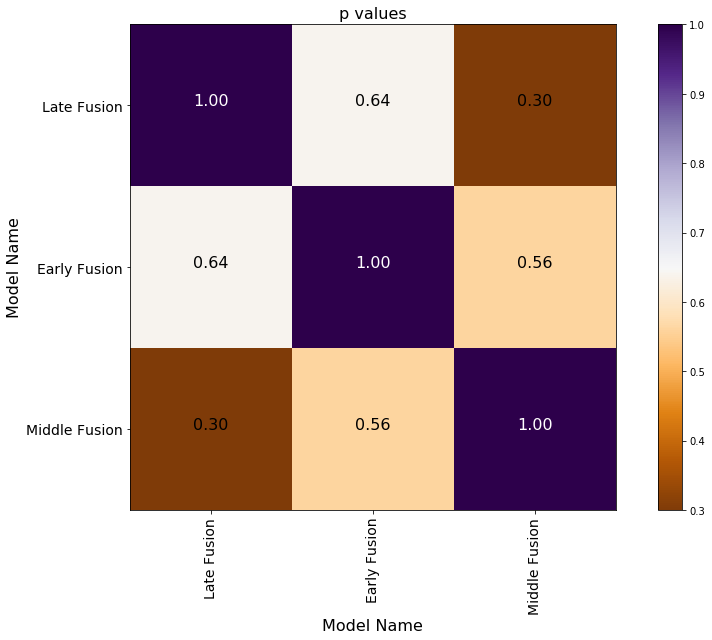

In [159]:
#p-values
#ttest
from scipy.stats import ttest_ind
results = pd.read_excel('fusion_results_pvalue.xlsx')

names = ['late', 'middle', 'early']

pmat = np.zeros((len(names), len(names)))
smat = np.zeros((len(names), len(names)))
for i in range(0, len(names)):
    an = names[i]
    a = results[['y_pred_'+an]].astype(int)
    for j in range(0, len(names)):
        bn = names[j]
        b = results[['y_pred_'+bn]].astype(int)
        s, p = ttest_ind(a,b, equal_var = False, axis = None)
        pmat[i,j] = p
        smat[i,j] = s
    print(i)
print(np.round(pmat, decimals=2))
#print(smat)
stats = dict()
stats['tstat'] = smat
stats['pvalue'] = pmat


def plot_p_matrix(cm, target_names, title='p values', cmap=None, normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('PuOr')#'Greens')

    fg = plt.figure(figsize=(8*1.5, 6*1.5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, fontsize=14, rotation=90)
        plt.yticks(tick_marks, target_names, fontsize=14)

#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]), fontsize=16,
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]), fontsize=16,
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    ##change labels
    plt.ylabel('Model Name', fontsize=16)
    plt.xlabel('Model Name', fontsize=16)#\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    
    plt.tight_layout()
    plt.show()
    return fg 
# fg = plot_confusion_matrix(np.round(pmat, decimals = 2) , normalize = False, target_names = ['BoW+GNB', 'tfIdf+GNB', 'word2vec+GNB', 'doc2vec+GNB', 'LSTM-random init', 'LSTM-word2vec init', 'LSTM-CLEVER w2v init', '1DCNN-random init', '1DCNN-word2vec init', '1DCNN-CLEVER word2vec init'])
# fg.savefig('structured_pred_label_p_values_w2v2_fmod.jpg',  bbox_inches='tight')

pmat2 = np.round(pmat, decimals=2)
print(pmat2)
# pmat2 = np.delete(pmat2, 6, axis=0)
# pmat2 = np.delete(pmat2, 6, axis=1)
# #print(pmat2)

fg = plot_p_matrix(pmat2 , normalize = True, target_names = ['Late Fusion', 'Early Fusion', 'Middle Fusion'])
fg.savefig('fusion_pmat.jpg', bbox_inches='tight')

In [28]:
from random import randint, sample

classifiers = [clf_demo, clf_pres, clf_icd, clf_cpt, clf_lab, clf_lf, clf_ef, model_mf]
test_sets = [X_demo_test, X_pres_test, X_icd_test, X_cpt_test, X_lab_test, X_merged_test_norm, X_merged_test, 
                 [X_demo_test, X_pres_test, X_icd_test, X_cpt_test, X_lab_test]]
names = ['demo', 'pres', 'icd', 'cpt', 'lab', 'late', 'early', 'middle']

# data_test = X_merged_test#[X_demo_test, X_pres_test, X_icd_test, X_cpt_test, X_lab_test]#
target_test = y_test
# classifier = clf_ef#model_mf
# flag_NN = 1 #if NN model is being tested
# flag_mf = 0 #if NN branched model is being tested
avg_precision = {}
avg_recall = {}
avg_fscore = {}

for name in names:
    avg_precision[name] = []
    avg_recall[name] = []
    avg_fscore[name] = []
    
test_set_size = len(target_test)
for i in range(1000):
    # randomly pick size of the test set
    i_size = randint(round(0.5*test_set_size), test_set_size)
    
    i_test_idx = sample([ii for ii in range(test_set_size)], i_size)
    i_test_idx.sort()
    
    for idx in range(len(test_sets)):
        data_test = test_sets[idx]
        classifier = classifiers[idx]
        name = names[idx]
        #print(name)
        if idx == 7:
            flag_mf = 1
        else:
            flag_mf = 0
    
        if flag_mf == 0:
            i_X_test = data_test[i_test_idx]
            flag_NN = 0
        else:
            i_X_test = [data_test[0][i_test_idx], data_test[1][i_test_idx], data_test[2][i_test_idx], 
                        data_test[3][i_test_idx], data_test[4][i_test_idx]]
            flag_NN = 1
    
        i_y_test = target_test[i_test_idx]

        i_y_pred = classifier.predict(i_X_test)
        if flag_NN == 1:
            i_y_pred = np.array([1 if yy > 0.5 else 0 for yy in i_y_pred])

        dct = classification_report(i_y_test, i_y_pred, output_dict=True, zero_division=0)
        avg_precision[name].append(dct['weighted avg']['precision'])
        avg_recall[name].append(dct['weighted avg']['recall'])
        avg_fscore[name].append(dct['weighted avg']['f1-score'])

    if i%100==0:
        print('Iteration:\t'+str(i))
        
# confidence intervals
alpha = 0.95
print('%.1f confidence interval ' % (alpha*100))

for name in names: 
    print(name)
    p = ((1.0-alpha)/2.0) * 100
    lower = np.percentile(avg_precision[name], p, axis= 0)
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = np.percentile(avg_precision[name], p, axis = 0)
    print('Precision')
    print('['+str(np.round(lower*100, decimals=1))+'-'+str(np.round(upper*100, decimals=1))+']')

    p = ((1.0-alpha)/2.0) * 100
    lower = np.percentile(avg_recall[name], p, axis= 0)
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = np.percentile(avg_recall[name], p, axis = 0)
    print('Recall')
    print('['+str(np.round(lower*100, decimals=1))+'-'+str(np.round(upper*100, decimals=1))+']')

    p = ((1.0-alpha)/2.0) * 100
    lower = np.percentile(avg_fscore[name], p, axis= 0)
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = np.percentile(avg_fscore[name], p, axis = 0)
    print('F-score')
    print('['+str(np.round(lower*100, decimals=1))+'-'+str(np.round(upper*100, decimals=1))+']')

Iteration:	0
Iteration:	100
Iteration:	200
Iteration:	300
Iteration:	400
Iteration:	500
Iteration:	600
Iteration:	700
Iteration:	800
Iteration:	900
95.0 confidence interval 
demo
Precision
[66.8-71.6]
Recall
[66.9-71.6]
F-score
[66.8-71.5]
pres
Precision
[70.8-75.4]
Recall
[67.2-71.8]
F-score
[66.7-71.4]
icd
Precision
[77.8-82.0]
Recall
[77.0-81.4]
F-score
[77.0-81.4]
cpt
Precision
[77.2-81.4]
Recall
[76.6-80.8]
F-score
[76.6-80.8]
lab
Precision
[74.5-78.8]
Recall
[74.3-78.6]
F-score
[74.3-78.6]
late
Precision
[81.3-85.1]
Recall
[81.1-85.0]
F-score
[81.1-84.9]
early
Precision
[82.1-85.8]
Recall
[82.1-85.8]
F-score
[82.1-85.8]
middle
Precision
[79.9-84.0]
Recall
[79.8-84.0]
F-score
[79.8-83.9]


In [30]:
Counter(df['ETHNIC_GROUP'].values[test_idx])

Counter({'Hispanic or Latino': 45,
         'Non-Hispanic or Latino': 425,
         'Unreported, Unknown, Unavailable': 135})

In [27]:
#3:black
#6:white
#10:hispanic

black_idx = [i for i in range(X_demo_test.shape[0]) if X_demo_test[i,3]==1]
print(len(black_idx))


white_idx = [i for i in range(X_demo_test.shape[0]) if X_demo_test[i,6]==1]
print(len(white_idx))


hispanic_idx = [i for i in range(X_demo_test.shape[0]) if X_demo_test[i, 10]==1]
print(len(hispanic_idx))

329
119
45


Demographics
Prescription
ICD-9
CPT
Labs
Late Fusion
Early Fusion
Middle Fusion


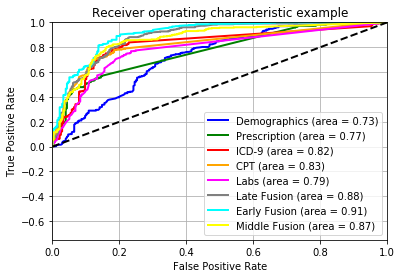

In [33]:
from sklearn.metrics import roc_curve, auc

race = 0

if race == 1:
    race_idx = hispanic_idx


classifiers = [clf_demo, clf_pres, clf_icd, clf_cpt, clf_lab, clf_lf, clf_ef, model_mf]
test_sets = [X_demo_test, X_pres_test, X_icd_test, X_cpt_test, X_lab_test, X_merged_test_norm, X_merged_test, 
                 [X_demo_test, X_pres_test, X_icd_test, X_cpt_test, X_lab_test]]

y_true = y_test
if race == 1:
    y_true = y_true[race_idx]
    
colors = ['blue', 'green', 'red', 'orange', 'magenta', 'grey', 'cyan', 'yellow', 'navy', 'purple']
labels = ['Demographics', 'Prescription', 'ICD-9', 'CPT', 'Labs', 'Late Fusion', 'Early Fusion', 'Middle Fusion']

plt.figure()
lw = 2

for i in range(len(classifiers)):
    label = labels[i]    
    print(label)
    classifier = classifiers[i]
    data_test = test_sets[i]
    if race == 1:
        if label == 'Middle Fusion':
            for d in range(len(data_test)):
                data_test[d] = data_test[d][race_idx,:]
        else:
            data_test = data_test[race_idx,:]
    color = colors[i]
    label = labels[i]
    if label == 'Middle Fusion':
        y_score = classifier.predict(data_test)
    else:
        y_score = classifier.predict_proba(data_test)[:,1]
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color=color,lw=lw, label=label+' (area = %0.2f)' % roc_auc)


plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([-0.75, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.grid()
plt.savefig('Figures2\\ROC_current3_5_modalities_tuned_middle_august_all.jpg')

plt.show()

Demographics
Prescription
ICD-9
CPT
Labs
Late Fusion
Early Fusion
Middle Fusion


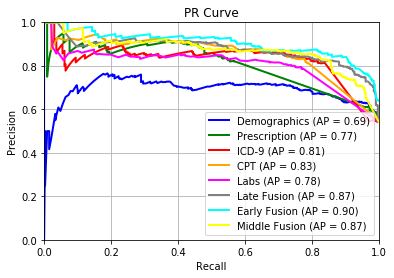

In [32]:
from sklearn.metrics import precision_recall_curve, average_precision_score

race = 0

classifiers = [clf_demo, clf_pres, clf_icd, clf_cpt, clf_lab, clf_lf, clf_ef, model_mf]
test_sets = [X_demo_test, X_pres_test, X_icd_test, X_cpt_test, X_lab_test, X_merged_test_norm, X_merged_test, 
                 [X_demo_test, X_pres_test, X_icd_test, X_cpt_test, X_lab_test]]
y_true = y_test
if race == 1:
    race_idx = hispanic_idx
    y_true = y_true[race_idx]
colors = ['blue', 'green', 'red', 'orange', 'magenta', 'grey', 'cyan', 'yellow', 'navy', 'purple']
labels = ['Demographics', 'Prescription', 'ICD-9', 'CPT', 'Labs', 'Late Fusion', 'Early Fusion', 'Middle Fusion']

plt.figure()
lw = 2

for i in range(len(classifiers)):
    label = labels[i]    
    print(label)
    classifier = classifiers[i]
    data_test = test_sets[i]
    color = colors[i]
    label = labels[i]
    
    if race == 1:
        if label == 'Middle Fusion':
            for d in range(len(data_test)):
                data_test[d] = data_test[d][race_idx,:]
        else:
            data_test = data_test[race_idx,:]
            
    if label == 'Middle Fusion':
        y_score = classifier.predict(data_test)
    else:
        y_score = classifier.predict_proba(data_test)[:,1]
    p, r, _ = precision_recall_curve(y_true, y_score)
    avg_precision = average_precision_score(y_true, y_score)
    #roc_auc = auc(fpr, tpr)

    plt.plot(r, p, color=color,lw=lw, label=label+' (AP = %0.2f)' % avg_precision)


#plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve')
plt.legend(loc="lower right")
plt.grid()
plt.savefig('Figures2\\PR_current3_5_modalities_tuned_middle_august_all.jpg')

plt.show()

In [48]:
imps = np.mean(clf_lf.coefs_[0], axis=1)
feat_importance = []
for i in range(0, 10, 2):
    feat_importance.append(imps[i]+imps[i+1])
len(feat_importance)

5

In [49]:
temp = pd.DataFrame()
#feat_importance = clf_lf.coef_[0]#feature_importances_
temp['Parts'] = ['Demographics', 'Prescriptions', 'ICD-9', 'CPT', 'Labs']
temp['Importance_HvI'] = feat_importance
temp.to_excel('Feature Importance\\feature_importance_current2_Late Fusion_ICU.xlsx')